In [315]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from src.path_loss import PathLossInHIndoorOffice, PathLossInHShoppingMalls
from src.network_sim import NetworkSimulator
from src.algorithm import wmmse, stochastic_wmmse
from src.sc import SyntheticControl
from src.experiment import ExperimentInterferenceModelComparison

%reload_ext autoreload
%autoreload 2
%aimport src

In [2]:
frequency_Hz= 50 * 1e9 # Hz
distance_m = 50
sample_size = 10

In [3]:
pd.DataFrame({
    'PathLossInHIndoorOffice':[PathLossInHIndoorOffice().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
    'PathLossInHShoppingMalls': [PathLossInHShoppingMalls().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
})

,PathLossInHIndoorOffice,PathLossInHShoppingMalls
0,-97.417484,-100.574273
1,-133.488088,-112.030474
2,-122.936042,-110.318018
3,-125.995534,-104.272712
4,-135.402031,-106.676176
5,-135.928709,-108.415390
6,-120.277649,-110.512475
7,-130.763917,-110.618748
8,-125.124523,-106.289922
9,-124.853737,-109.409400


In [343]:
simulator = NetworkSimulator(Tx_radius=200, Rx_radius=100, num_Tx_netA=3, num_Rx_per_Tx_netA=5, num_Tx_netB=2, num_Rx_per_Tx_netB=5)

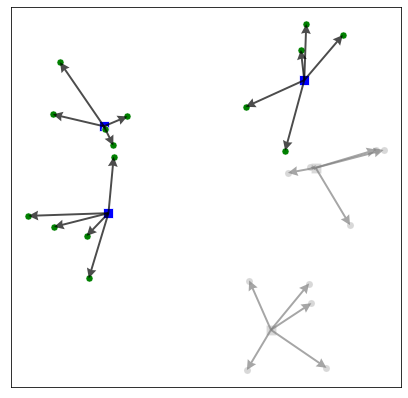

In [344]:
simulator.plot_network()

In [345]:
pd.DataFrame(simulator.gain_mat_dBm)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-105.341381,-117.696757,-112.162116,-121.569747,-118.919909,-153.927704,-143.258177,-149.452475,-165.661450,-170.490644,...,-156.396501,-165.194918,-151.319201,-148.752039,-161.320349,-163.557287,-146.662417,-144.815419,-146.149506,-132.742996
1,-158.606296,-168.286093,-151.810286,-176.791691,-170.749186,-116.139948,-109.418588,-116.049804,-110.933929,-107.562982,...,-122.968015,-139.317240,-123.377739,-109.616720,-117.658594,-161.300481,-168.223200,-150.925758,-150.078474,-154.116388
2,-118.373594,-130.739786,-120.521002,-130.995128,-135.972183,-142.065086,-153.528656,-136.727256,-157.746595,-162.604190,...,-176.608349,-155.653516,-140.994565,-158.937796,-150.341583,-173.264764,-154.943899,-170.707588,-159.398396,-156.043292
3,-155.253997,-157.985088,-153.638831,-157.011725,-153.530478,-125.819510,-128.613864,-103.524502,-133.853794,-145.756863,...,-111.001875,-112.320225,-115.407575,-89.157219,-107.061393,-157.290285,-148.467594,-131.251170,-129.917766,-122.650116
4,-152.971987,-158.042080,-153.426933,-164.178686,-143.440430,-161.267448,-172.551789,-161.065079,-166.788560,-187.038657,...,-157.917379,-128.547719,-136.751896,-135.243495,-159.159658,-117.613375,-118.936376,-117.718248,-101.824311,-111.980446


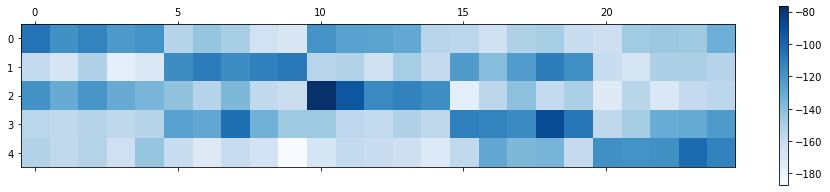

In [346]:
simulator.plot_gain_mat()

## Model Comparisons

In [347]:
simulator.weighted_sum_rate_Gnats([200 for i in range(simulator.num_Rx)], Rx_weights=np.ones(simulator.num_Rx))

246.51165039056326

In [348]:
model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
model_comparison.data_generation(num_samples=100, max_power=500, netB_power_mode='zero')
model_comparison.modeling()

In [349]:
model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='zero')

Weighted Sum Rate: 238.64680217278953 Convergence Error at Round 5000 0.04179576208616435


,interference,sc_bias,lr_bias
0,1.365681e-07,-0.941218,1.550569e-15


In [350]:
model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='dependent')

,interference,sc_bias,lr_bias
0,1.374396e-07,-0.93307,-0.006341


In [351]:
model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='uniform')

,interference,sc_bias,lr_bias
0,1.373159e-07,-0.93422,-0.005446


## Algorithm Comparisons

In [365]:
max_power = 200
netB_power_training_mode = 'zero' # ['dependent', 'zero', 'random']
netB_power_testing_mode = 'dependent' # ['dependent', 'zero', 'random', 'uniform']

max_iterations = 300

model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
model_comparison.data_generation(num_samples=100, max_power=max_power, netB_power_mode=netB_power_training_mode)
model_comparison.modeling(synthetic_constrained=False)
starting_powers_mW = [1e-5 for i in range(simulator.num_Rx)]
# Rx_weights = np.random.uniform(0.1, 1, simulator.num_Rx)
Rx_weights = np.ones(simulator.num_Rx)

In [366]:
rates_original_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='original',
    interference_models=[],
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

Denominator: 1.2454462776340395e-09
Weighted Sum Rate: 180.21937855420774
Power: [5.96081861e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.58793032e+02 1.40844078e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00], [ 60.11756171 134.47828338   0.           0.           0.
 108.407454     0.           0.           0.           0.        ]
Convergence Error at Round 300 0.13741683209441136


In [367]:
rates_local_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='local',
    interference_models=[],
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

Denominator: 5.697965040454559e-10
Weighted Sum Rate: 177.74168967451757
Power: [4.62831887e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.42011369e+02 1.10840618e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00], [ 54.12097531 119.97444284   0.           0.           0.
  97.38129955   0.           0.           0.           0.        ]
Convergence Error at Round 300 0.07971491160649345


In [368]:
rates_sc_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='sc_estimate',
    interference_models=model_comparison.sc_models,
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

In [ ]:
rates_lr_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='lr_estimate',
    interference_models=model_comparison.lr_models,
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

Denominator: 1.7996781078505728e-09
Weighted Sum Rate: 143.94218997753615
Power: [  8.55361159   0.           0.           0.           0.
   0.           0.           0.           0.         200.
   0.21178885   0.           0.           0.           0.        ], [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]
Convergence Error at Round 300 0.013156663372120821


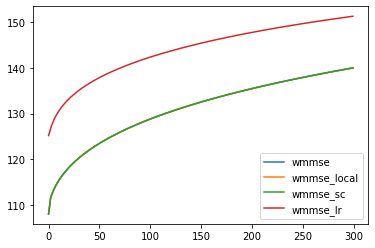

In [ ]:
data = pd.DataFrame({
    'wmmse': rates_original_method,
    'wmmse_local': rates_local_method,
    'wmmse_sc': rates_sc_method,
    'wmmse_lr': rates_lr_method,
})
data.plot();